# Machine Learning Algorithms 2022 - Assignment 2

---

This assignment has been written by:

- $\text{Karoline Moser, m12001627}$
- $\text{Lucas Weitering, m12003360}$
- $\text{Philipp Zeni, m12007500}$

---

## Task description

Construct classifiers that can distinguish the digits in the alldigits dataset. Compare the accuracy of a Support Vector Machine and a Neural Network classifier, using the sklearn library. The goal is to train highly accurate classifiers.

The alldigits CSV file contains 28x28 grey value pixel images with the label in the last column.

Do the assignment in groups of three. (You may include a minority statement, if you do not agree with the solution of the group.) One group with a single student xor at most two groups of two are allowed. A single student plus a group of two is not allowed. 

- How did you construct the classifiers? 
- What is the accuracy of your classifiers? 
- How did you calculate the accuracy of your classifiers? 
- Which classifier is more accurate?
- How confident are you in your accuracy estimate?

---

## Definition of input files

In [ ]:
digits_train_filename = 'alldigits.csv'

## Import statements

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from statsmodels.stats.proportion import proportion_confint
import sklearn.svm

## Read data

Due to the used Machine Learning algorithms, we have to standardize the used data. To do that we use the *sci-kit* module *preprocessing*. 

In [ ]:
digits_train = np.loadtxt(digits_train_filename, delimiter=',', skiprows=1)

scaler = preprocessing.StandardScaler().fit(digits_train[:,:-1])
digits_train_scaled = scaler.transform(digits_train[:,:-1])

## Explore

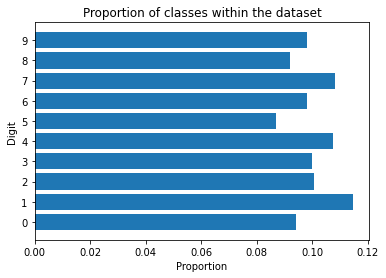

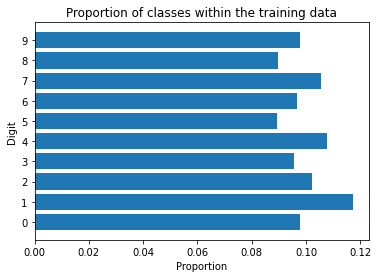

In [ ]:
def plot_data_information(classes, title_string):
    digits, counts = np.unique(classes, return_counts = True)
    proportion = counts/sum(counts)
    plt.barh(digits, proportion)
    plt.yticks(digits)
    plt.xlabel("Proportion")
    plt.ylabel("Digit")
    plt.title(title_string)
    plt.show()

plot_data_information(digits_train[:, -1], "Proportion of classes within the dataset")

data = digits_train_scaled
labels = digits_train[:, -1]

train_data, test_data, train_labels, test_labels = train_test_split(data,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=0) 
plot_data_information(train_labels, "Proportion of classes within the training data")

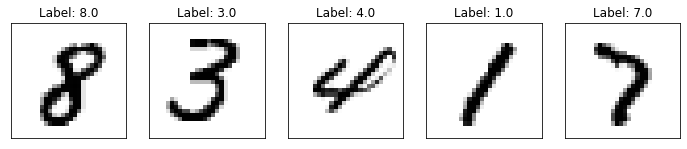

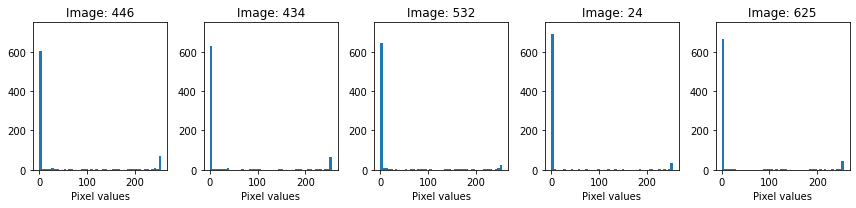

In [ ]:
def plot_random_digits(data):
    indices = [np.random.randint(low=0, high=data.shape[1]) for i in range(0, 5)]
    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(len(axs)):
        img = np.reshape(data[indices[i] , :-1], (28, -1)).T
        label = data[indices[i], -1]
        axs[i].imshow(img, cmap='gray_r')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f'Label: {label}')
    plt.show()

    fig, axs = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(len(axs)):
        img = data[indices[i], :-1]
        label = data[indices[i], -1]
        axs[i].hist(img, bins=50)
        axs[i].set_title(f'Image: {indices[i]+1}')
        axs[i].set_xlabel("Pixel values")
        axs[i].set_ylim(0, 750)
    plt.tight_layout()
    plt.show()

plot_random_digits(digits_train)

## Support Vector Machines

Support Vector Machines are algorithms located within supervised machine learning. Using *sci-kit* implementations, we can perform both binary and multi-class classifications. Note, however, that Support Vector Machines can only perform binary classifications, since points, lines, planes or hyperplanes (for $\mathbb{R}^1, \mathbb{R}^2, \mathbb{R}^3$ and $\mathbb{R}^n$ respectively) are used to differentiate between classes. To enable multi-class classification we have to combine the results of multiple Support Vector Classifiers.  

In the documentation (https://scikit-learn.org/stable/modules/svm.html#multi-class-classification) we can find, that the "one-versus-one" approach is being used. This means that we train $n_{classes} * (n_{classes} - 1) / 2$ classifiers in total. Each of these classifiers is trained on data from two classes and will thus classify samples only as one of these two classes. The sample is then classified by a majority vote amongst all binary classifiers. The majority vote is mathematically defined as the $argmax$ of the sum of scores, where score means the classification of binary classifiers. Since classifications are made using hyperplanes, there is no probabilistic clarification for the classification.

The calculation of hyperplanes has to deal with outliers and/or mislabelled data. To do that, a so-called soft-margin can be introduced. A commonly used cost metric is the *Hinge Loss*. This approach causes the Support Vector Machine to minimize $(\frac{1}{margin} + \sum{penalty})$, where margin is the nearest (correctly classified) point to the hyperplane and the penalty is proportional to the distance of violation.

### Kernel functions
Kernels are used to map non-linearly seperable data to higher dimensions, where they then can be linearly seperated. A visualization of this process can be found in the picture below. 



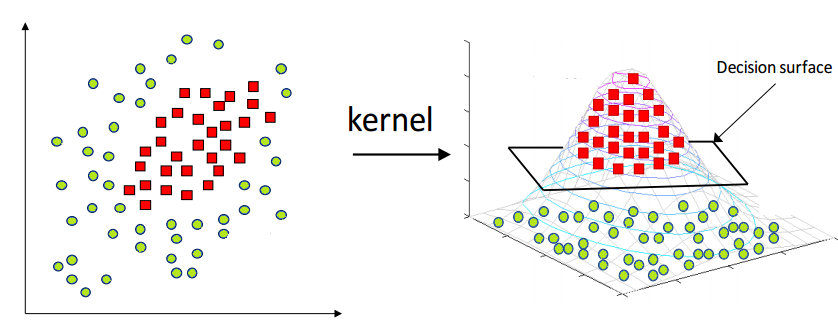

Some kernel functions that SVMs use will be explained in the following:
#### Linear Kernel:
A linear kernel is used for linearly seperable data, meaning data that can be seperated by a single point, line, plane or hyperplane. 

Mathematically formulated: $\langle x, x' ⟩$


#### Polynomial Kernel:
With the polynomial kernel the similarity of vectors are represented by polynomials of the original variables in a feature space. This means, that the input space gets transformed according to the following formula:

$ K(x, y) = (\langle x, y\rangle + r)^d$ 

Where $x$ and $y$ are vectors in the input space, $r$ is a free parameter that regulates the influence of higher- and lower-order terms and $d$ represents the degree of the polynomial. 

#### RBF Kernel:
The Radial Basis Function kernel is the default kernel for *sklearn*'s SVM classification algorithms. Mathematically it is defined as follows:

$K(x, y) = e^{-γ||x - y||^2}$

Where $x$ and $y$ are vectors in the input space and $γ$ has to be set manually ($γ > 0$). The default value for $γ$ is $\frac{1}{n_{features}*σ^2}$.

By manipulating $γ$, we can control how individual points influence the whole algorithm. Large $γ$ mean that points have to be closer to significantly affect predictions later on. On the opposite, smaller $γ$ force the model to take other points into account, when generating a prediction or classification.

---

## Optimizing Functions

The function *get_best_params* will use a given model and training data to find the best parameters with the help of GridSearchCV. Afterwards the found parameters will be returned.

The function *get_test_score* will take a model and test data as an input, calculate the score and return it afterwards.

In [ ]:
def get_best_params(model:sklearn, train_data, train_labels, params_dict:dict) -> dict:
  clf = GridSearchCV(model, params_dict)
  params_keys = clf.fit(train_data, train_labels)

  return params_keys.best_params_

def get_test_score(model:sklearn, test_data, test_labels) -> [sklearn, float]:
  
  model.fit(train_data, train_labels)
  score = model.score(test_data, test_labels)

  return model, score

---

## SVC


In [ ]:
# BestParamsFound (Runtime ~ 25 min): {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

# enter all parameters you want to test in the GridSearch
params = {'C': [10, 1, 0.1], 
          'kernel': ['poly', 'rbf'],
          'degree': [2, 3, 4],
          'gamma': ['scale', 'auto'],
          'coef0': [0.0, 0.1, 0.5, 1]} 

best_params_SVC = get_best_params(SVC(), train_data, train_labels, params)
print("Best parameters for the model:")
print(best_params_SVC)

Best parameters for the model:
{'C': 10, 'coef0': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
model = SVC(C=best_params_SVC.get('C'),
            kernel=best_params_SVC.get('kernel'),
            degree=best_params_SVC.get('degree'),
            gamma=best_params_SVC.get('gamma'),
            coef0=best_params_SVC.get('coef0'))

trained_model_SVC, score_SVC = get_test_score(model, test_data, test_labels)
print(f"Model Score: {score_SVC}")

Model Score: 0.9516666666666667


## NuSVC

In [ ]:
# BestParamsFound (Runtime ~ 1h 35min): {'coef0': 0.5, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'nu': 0.01} --> 0.945

# enter all parameters you want to test in the GridSearch

params = {'nu': [0.9, 0.5, 0.1, 0.05, 0.01],
          'kernel': ['poly', 'rbf'],
          'degree': [2, 3, 4],
          'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
          'coef0': [1, 0.5, 0.1, 0.05]}

best_params_NuSVC = get_best_params(NuSVC(), train_data, train_labels, params)
print("Best parameters for the model:")
print(best_params_NuSVC)

Best parameters for the model:
{'coef0': 0.5, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'nu': 0.01}


In [ ]:
model = NuSVC(nu=best_params_NuSVC.get('nu'),
              kernel=best_params_NuSVC.get('kernel'),
              degree=best_params_NuSVC.get('degree'),
              gamma=best_params_NuSVC.get('gamma'),
              coef0=best_params_NuSVC.get('coef0'))

trained_model_NuSVC, score_NuSVC = get_test_score(model, test_data, test_labels)
print(f"Model Score: {score_NuSVC}")

Model Score: 0.9558333333333333


---

## Neural Network - MLPClassifier

Neural Networks are algorithms located within supervised as well as unsupervised machine learning. 

It consists of one input layer, some hidden layers and an output layer. The algorithm learns a function $f: \mathbb{R}^m \rightarrow \mathbb{R}^o$, $m$ represents the number of dimensions for input and $o$ the number of dimensions for the output. Given a set of features $X = x_1, x_2, ..., x_m$ and a target $y$, it can learn nonlinear function approximation for classifications. 


The input layer, normally visualized as the leftmost layer, consists of a set of neurons that represent the input features. The neurons in the hidden layer transform values from the previous layer with a weighted linear summation $\sum_{i=1}^m w_ix_i$, followed by a nonlinear activation function $g: \mathbb{R} \rightarrow \mathbb{R}$ . These activation functions are called kernels. The output layers receive the output from the last hidden layer and transforms them into output values.

The version implemented by *sci-kit*, MLPClassifier, is trained using backpropagation. More precisely, it is trained using some form of gradient descent and the gradients are calculated using backpropagation. For classification we minimize the Cross-Entropy loss function giving us a vector of probability estimates $P(y|x)$ per sample $x$. 

MLPClassifiers apply softmax as the output function, which allows them to perform multi-class classifications. The softmax function, also called normalized exponential function, is used in probability theory to calculate a categorical distribution. It rescales all components of the last layer, such that the components will add up to 1, meaning that they can be interpreted as probabilities.


### Activation Functions
#### Sigmoid or Logistic Activation Function
The main reason to use the sigmoid function is its existence between 0 and 1,
which mimics probability values. The function is expressed mathematically as follows:
$$ Φ(z) = \frac{1}{1+e^{-z}} $$
We can observe that the gradient of the sigmoid function is always between 0 and 0.25. As $z$ tends to positive or negative infinity, the gradient tends to 0. This could contribute to the so called vanishing gradient problem, where the gradient gets too small to initiate correction.

#### ReLU (Rectified Linear Unit) Activation Function
ReLU is a fairly common activation function. Its popularity originates in its relatively simple computation, meaning that Neural Networks can be accelerated while still maintaining empirically good performance. Mathematically it is represented as:
$$ f(z) = max(0,z) $$
So the gradient equals $1$ for $ z \geq 0 $ and $0$ else. This can lead to another problem in which a neuron is persistently inactivated. In this case, the weights are no longer updated.

### Solver
#### LBFGS (Limited-memory BFGS)
LBFGS is an optimization algorithm in the family of the quasi-Newton methods that approximates the Broyed-Fletcher-Goldfarb-Shanno algorithm (BFGS) using a limited amout of computer memory. Quasi-Newton methods are methods used to find zeros or local maxima and minima of functions. The BFGS algorithm is an iterative method to solving unconstrained nonlinear optimization problems. For small datasets LBFGS can converge faster and perform better than the adam solver.

#### SGD (Stochastic Gradient Descent)
SGD is a simple and efficient approach to fitting linear classifiers and their convex loss-functions. SGD has been successfully applied to large-scale and sparse Machine Learning problems often encountered in text classfication and natural language processing.

#### Adam
The Adam optimizer is the extended version of Stochastic Gradient Descent. Its name is derived from adaptive moment estimation. Adam combines the advantages of two extensions of SGD:
- Adaptive Gradient Algorithm  
- Root Mean Square Propagation

In [ ]:
# bestParamsFound (~ 2h 30min): {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}

params = {'hidden_layer_sizes':[(100,), (80, ), (60, )], 
          'activation': ['logistic', 'relu'], 
          'solver': ['lbfgs', 'sgd', 'adam'], 
          'alpha': [5, 1.5, 1, 0.5, 0.1, 0.05, 0.01], 
          'learning_rate': ['constant', 'adaptive'],
          'learning_rate_init': [0.001],
          'max_iter': [300]} 

best_params_MLPClasifier = get_best_params(MLPClassifier(), train_data, train_labels, params)
print("Best parameters for the model:")
print(best_params_MLPClasifier)

Best parameters for the model:
{'activation': 'relu', 'alpha': 1.5, 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}


In [ ]:
model = MLPClassifier(hidden_layer_sizes=best_params_MLPClasifier.get('hidden_layer_sizes'),
                      activation=best_params_MLPClasifier.get('activation'),
                      solver=best_params_MLPClasifier.get('solver'),
                      alpha=best_params_MLPClasifier.get('alpha'),
                      learning_rate=best_params_MLPClasifier.get('learning_rate'),
                      learning_rate_init=best_params_MLPClasifier.get('learning_rate_init'))

trained_model_MLPClassifier, score_MLPClassifier = get_test_score(model, test_data, test_labels)
print(f"Model Score: {score_MLPClassifier}")

Model Score: 0.9425


---

## Final classifiers

In [ ]:
print("SVC:")
print(trained_model_SVC.get_params())
print("-------------------------------------------")
print("NuSVC:")
print(trained_model_SVC.get_params())
print("-------------------------------------------")
print("MLPClassifier:")
print(trained_model_MLPClassifier.get_params())

SVC:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.1, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
-------------------------------------------
NuSVC:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.1, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
-------------------------------------------
MLPClassifier:
{'activation': 'relu', 'alpha': 1.5, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 

### Confidence Interval for Classification Accuracy

The classification accuracy is a proportion or ratio, that describes the proportion of correct predictions made by the model. As each prediction is a binary decision, meaning its outcomes can only be correct or incorrect, each prediction is called a Bernoulli trial. The proportions resulting from repeated trials are binomially distributed. From this we can calculate the binomial proportion confidence interval to get a better understanding of the general performance of the used model.

In Assignment I for Machine Learning Algorithms we used the *Normal approximation* or *Wald* interval:

$$ \frac{n_{S}}{n} ± \frac{z}{n \sqrt{n}} \sqrt{n_{S} n_{F}} $$

Where the variables mean:
- $n$ - Number of trials
- $n_{S}$ - Number of successes
- $n_{F}$ - Number of failures
- $z$ - The $1 - \frac{α}{2} $ quantile of the normal distribution

According to [Brown, Cai and DasGupta](https://projecteuclid.org/journals/statistical-science/volume-16/issue-2/Interval-Estimation-for-a-Binomial-Proportion/10.1214/ss/1009213286.full) the *Wald* intervals erratic behaviour of the coverage probability makes said method not fit for practical use. In their concluding remarks it is stated, that for larger $n$ the *Wilson*, *Jeffreys* and the *Agresti-Coull* interval are comparable. They then go on to recommend using the latter of those methods, as it is the simplest to present. Because of this, we will be using the *Agresti-Coull* interval in this assignment.
Using the same notations as above, the *Agresti-Coull* interval can be formulated as follows:

We define 

$\tilde{n} = n + z^2$ 

and 

$\tilde{p} = \frac{1}{n} (n_{S} + \frac{z^2}{2})$

The confidence interval is then given by

$\tilde{p} \pm z \sqrt{\frac{\tilde{p}}{\tilde{n}}(1-\tilde{p})}$



------------- Model Scores -------------
SVC:              0.9516666666666667
NuSVC:            0.9558333333333333
MLPClassifier:    0.9425
----------------------------------------



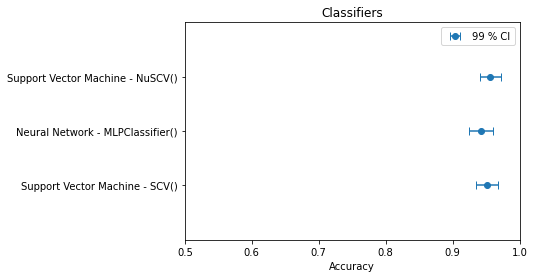

In [ ]:
all_scores = [score_SVC, score_MLPClassifier, score_NuSVC]
print("------------- Model Scores -------------")
print(f"SVC:              {score_SVC}")
print(f"NuSVC:            {score_NuSVC}")
print(f"MLPClassifier:    {score_MLPClassifier}")
print("----------------------------------------")
print()

conf_int_svc = proportion_confint(len(test_labels)*score_SVC, len(test_labels), alpha=0.01, method='agresti_coull')
conf_int_nn = proportion_confint(len(test_labels)*score_MLPClassifier, len(test_labels), alpha=0.01, method='agresti_coull')
conf_int_Nusvc = proportion_confint(len(test_labels)*score_NuSVC, len(test_labels), alpha=0.01, method='agresti_coull')

all_conf_intervals = [conf_int_svc, conf_int_nn, conf_int_Nusvc]

plt.errorbar(all_scores, np.arange(len(all_scores)), xerr=np.abs(np.mean(all_conf_intervals, 1) - np.array(all_conf_intervals).T), capsize=4, fmt='o')
plt.yticks(np.arange(len(all_scores)), ["Support Vector Machine - SCV()", "Neural Network - MLPClassifier()", "Support Vector Machine - NuSCV()"])
plt.ylim([-1, len(all_scores)])
plt.xlim([0.5,1])
plt.xlabel("Accuracy")
plt.title("Classifiers")
plt.legend(['99 % CI'])
plt.show()

---

## Summary

We did not implement the *LinearSVC()*, as it has no additional advantages, when compared to the other two (*SVC()* and *NuSVC()*). It could be implemented, if we knew that the linear kernel happened to be sufficient.

We did not use any other Neural Network implementation than *MLPClassifier()*, as none of them are laid out to perform classifications. 

After optimizing many combinations of parameters, the implemented classifiers show almost equal accuracies. To decide which one of these algorithms performed best, we would need to conduct a statistical test. 
